In [1]:
from model import *
from SeLUNet_model import *
from ResUNet_model import *
from data import *
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


# Training

In [2]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(5,'data/membrane/train_old','image','label',data_gen_args,save_to_dir = None)
model = unet3()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
history = model.fit_generator(myGene,steps_per_epoch=500,epochs=10,callbacks=[model_checkpoint])

E:\我的雲端硬碟\Python\untitled\medical_ai\Final_project\Plan2\unet-master-2\model.py:197: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input=inputs, output=conv10)


Epoch 1/10
Found 41 images belonging to 1 classes.
Found 41 images belonging to 1 classes.
500/500 [==============================] - 157s 313ms/step - loss: 0.0537 - accuracy: 0.9833

Epoch 00001: loss improved from inf to 0.05374, saving model to unet_membrane.hdf5
Epoch 2/10
500/500 [==============================] - 148s 297ms/step - loss: 0.0290 - accuracy: 0.9887

Epoch 00002: loss improved from 0.05374 to 0.02893, saving model to unet_membrane.hdf5
Epoch 3/10
500/500 [==============================] - 148s 297ms/step - loss: 0.0150 - accuracy: 0.9938

Epoch 00003: loss improved from 0.02893 to 0.01504, saving model to unet_membrane.hdf5
Epoch 4/10
500/500 [==============================] - 148s 296ms/step - loss: 0.0109 - accuracy: 0.9955

Epoch 00004: loss improved from 0.01504 to 0.01075, saving model to unet_membrane.hdf5
Epoch 5/10
500/500 [==============================] - 149s 297ms/step - loss: 0.0105 - accuracy: 0.9957

Epoch 00005: loss improved from 0.01075 to 0.01041,

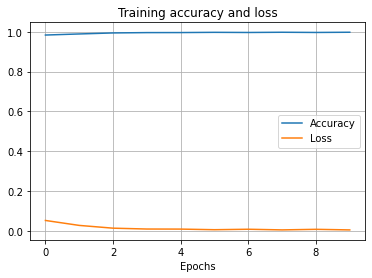

In [3]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
epoch = [i for i in range(len(acc))]

plt.figure()
plt.plot(epoch, acc, label='Accuracy')
plt.plot(epoch, loss, label='Loss')
plt.grid('on')
plt.xlabel('Epochs')
plt.title('Training accuracy and loss')
plt.legend()
plt.show()

# Testing

In [4]:
testGene = testGenerator("data/membrane/test")
results = model.predict_generator(testGene,15,verbose=1)
saveResult("data/membrane/results",results)

15/15 [==============================] - 0s 33ms/step


E:\我的雲端硬碟\Python\untitled\medical_ai\Final_project\Plan2\unet-master-2\data.py:127: UserWarning: data/membrane/results\1.tif is a low contrast image
  io.imsave(os.path.join(save_path, "%d.tif" % i), img_as_float(img))
E:\我的雲端硬碟\Python\untitled\medical_ai\Final_project\Plan2\unet-master-2\data.py:127: UserWarning: data/membrane/results\3.tif is a low contrast image
  io.imsave(os.path.join(save_path, "%d.tif" % i), img_as_float(img))
E:\我的雲端硬碟\Python\untitled\medical_ai\Final_project\Plan2\unet-master-2\data.py:127: UserWarning: data/membrane/results\9.tif is a low contrast image
  io.imsave(os.path.join(save_path, "%d.tif" % i), img_as_float(img))
E:\我的雲端硬碟\Python\untitled\medical_ai\Final_project\Plan2\unet-master-2\data.py:127: UserWarning: data/membrane/results\11.tif is a low contrast image
  io.imsave(os.path.join(save_path, "%d.tif" % i), img_as_float(img))
E:\我的雲端硬碟\Python\untitled\medical_ai\Final_project\Plan2\unet-master-2\data.py:127: UserWarning: data/membrane/results\12.t

# Evaluation

### Single image

In [5]:
import umetrics
from skimage.io import imread
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from evaluation_matrix import *

true_path = glob.glob("data/membrane/test_mask/*.png")
pred_path = glob.glob("data/membrane/results/*.tif")
true_path.sort()
pred_path.sort()
true_imds = []
pred_imds = []
for i in range(len(true_path)):
    img1 = Image.open(true_path[i])
    img1 = np.array(img1)
    img1 = img1[:,:,:3][:,:,0]
    img1 = img1 / 255
    img1[img1>0] == 1

    img2 = Image.open(pred_path[i])
    img2 = np.array(img2)
    img2 = cv2.resize(img2,(150,150))
    img2[img2>0] == 1
    
    true_imds.append(img1)
    pred_imds.append(img2)
    
def evaluation(pred, true, verbose=1):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    threshold = 0.5
    for i, j in zip(pred, true):
        for x, y in zip(i, j):
            if x >= threshold and y >= threshold:
                tp += 1
            elif x < threshold and y < threshold:
                tn += 1
            elif x >= threshold and y < threshold:
                fp += 1
            elif x < threshold and y >= threshold:
                fn += 1
    sen = tp/(tp+fn)
    spe = tn/(tn+fp)
    iou = tp/(fn+fp+tp)
    dice = tp/(2*tp+fn+fp)
    
    if verbose==1:
        print("============================")
        print("Dice score : {:0.4f}".format(dice))
        print("Sensitivity score : {:0.4f}".format(sen))
        print("Specificity score : {:0.4f}".format(spe))
        print("IoU score : {:0.4f}".format(iou))
        print("============================")
    return dice, sen, spe, iou

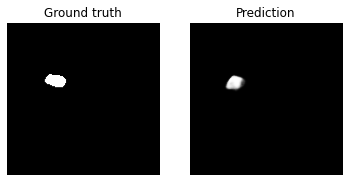

Dice score : 0.2983
Sensitivity score : 0.5294
Specificity score : 0.9978
IoU score : 0.4252


In [6]:
num = 4

plt.figure()
plt.subplot(121)
plt.imshow(true_imds[num], cmap='gray')
plt.title('Ground truth')
plt.axis("off")
plt.subplot(122)
plt.imshow(pred_imds[num], cmap='gray')
plt.title('Prediction')
plt.axis("off")
plt.show()

# print(result.results)
sen, spe, iou, dice = evaluation(pred_imds[num], true_imds[num])

### Multiple images

In [7]:
dice = []
sen = []
spe = []
IOU = []

for i in range(len(pred_imds)):
    dices, sens, spes, ious = evaluation(pred_imds[i], true_imds[i], verbose=0)
    dice.append(dices)
    sen.append(sens)
    spe.append(spes)
    IOU.append(ious)
Dice = np.mean(dice)
Sen = np.mean(sen)
Spe = np.mean(spe)
IoU = np.mean(IOU)

print("============================")
print("Dice score : {:0.4f}".format(Dice))
print("Sensitivity score : {:0.4f}".format(Sen))
print("Specificity score : {:0.4f}".format(Spe))
print("IoU : {:0.4f}".format(IoU))
print("============================")

Dice score : 0.3469
Sensitivity score : 0.6198
Specificity score : 0.9994
IoU : 0.5938
